## Text Processing
<li>Extract short lyrics</li>
<li>Create short lyric table</li>

## Formal Structure
<li>CMU Pronouncing Dictionary</li>
<li>Assonance Function</li>

## Concreteness/Abstractness
<li>WordNet Processing</li>
<li>Defining concreteness metric</li>
<li>Normalization by line</li>

## Classification
<li>Flat clustering of lines</li>

# Preparation

In [313]:
%pylab inline
import numpy as np
from datascience import *
import pandas as pd
import string
import nltk
from nltk.corpus import cmudict

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [314]:
modules = ["averaged_perceptron_tagger", "maxent_ne_chunker", "punkt",\
           "words", "cmudict", "wordnet"]

for module in modules:
    nltk.download(module)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/kimia/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/kimia/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package punkt to /Users/kimia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/kimia/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package cmudict to /Users/kimia/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kimia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [315]:
##Constants
invalid_input = 'nan'
max_length = 10

In [316]:
##Read in files
with open('pound_poems.txt') as file_in:
    collection = file_in.read()
collection_list = collection.split('\n'*5)

In [317]:
titles = []
dates = []
collections = []
lines = []
poem_length = []
for poem in collection_list:
    line_list = poem.split('\n')
    dates.append(line_list.pop(0))
    collections.append(line_list.pop(0))
    titles.append(line_list.pop(0))
    lines.append(line_list)
    poem_length.append(len(line_list))

In [318]:
raw_poem_tb = Table().with_columns([
        'Title', titles,
        'Text', lines,
        'Number of Lines', poem_length,
        'Publication Date', dates,
        'Anthology', collections
    ]).sort('Publication Date')

In [319]:
reception_mask = (raw_poem_tb['Number of Lines'] <= max_length)
short_lyric_tb = raw_poem_tb.where(reception_mask)

In [320]:
##Re-organize table with one poem per column
poem_tb = Table(short_lyric_tb['Title'])
construct_columns = [[], [], [], [], [], [], [], [], [], []]
for poem in short_lyric_tb['Text']:
    for x in range(0, max_length):
        if x < len(poem):
            construct_columns[x].append(poem[x])
        else:
            construct_columns[x].append(invalid_input)
poem_tb = poem_tb.with_rows(construct_columns)

In [ ]:
poem_tb

# Analysis

In [321]:
#Final data table containing results of study
output_tb = Table().with_column('Title', short_lyric_tb['Title'])

## Measuring Formal Structure

In [322]:
def cleaned_line(line):
    s = line
    s = "".join(char for char in s if char not in string.punctuation)
    s = s.replace('-', ' ')
    return s.lower()

In [323]:
def final_words(poem):
    return [line.rsplit(None, 1)[-1] for line in poem if line != invalid_input]

In [324]:
# list of words for which we have pronunciations
words = cmudict.words()      
# keys are words, values are lists of pronunciations for each word
dictionary = cmudict.dict()  
# list of tuples, where first entry is word, second is pronunciation
entries = cmudict.entries()  

***Consider re-writing so that this returns 1 or 0 instead of a predicate***

In [325]:
'''Formal structure for the purpose of this study is measured by assonance 
as defined below'''
def is_assonant(word1, word2):
    if dictionary.get(word1) == None or dictionary.get(word2) == None:
        return False
    sounds1 = [char for char in dictionary.get(word1)[0] if len(char) > 2]
    sounds2 = [char for char in dictionary.get(word2)[0] if len(char) > 2]
    for char1 in sounds1:
        for char2 in sounds2:
            if (char1[0:2] == char2[0:2]):
                return True
    return False

**Optimize this function it's a mess. Other potential changes:**
<li>Every other line assonance</li>
<li>Inter-line assonance</li>
<li>Some constraints: I don't want 'tissue' and 'napkin' to be assonant,       but I do want 'me' and 'morality' to be assonant, for example. Try, if     the emphasis is on the same syllable OR the sound occurs at the end of     the word.</li>

In [350]:
#Assigns value of 1 to rhyming lines and value of 0 to non-rhyming lines
def apply_rhyming_metric(poem):
    numeric_translation = []
    for i in range(len(poem)):
        numeric_translation.append(0)
    for i in range(len(poem) - 1):
        if is_assonant(poem[i], poem[i+1]):
            if numeric_translation[i] < 1:
                numeric_translation[i] += 1
            if numeric_translation[i+1] < 1:
                numeric_translation[i+1] += 1
        '''
        The following code attempts to consider lines offset by one
        if i < len(poem) - 2:
            if is_assonant(poem[i], poem[i+2]):
                if numeric_translation[i] < 1:
                    numeric_translation[i] += 1
                if numeric_translation[i+2] < 1:
                    numeric_translation[i+2] += 1
        '''
    return numeric_translation

In [351]:
#Get rid of punctuation
short_lyrics = short_lyric_tb['Text']
cleaned_poems = []
for poem in short_lyrics:
    cleaned_poems.append([cleaned_line(line) for line in poem])

In [352]:
#Create column array measuring formal structure
formal_structure = [
    apply_rhyming_metric(final_word(poem)) for poem in cleaned_poems]

In [353]:
output_tb = output_tb.with_column('Form', formal_structure)

## Measuring Abstractness

In [354]:
##Import stemming tools
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball  import SnowballStemmer
from nltk.stem import WordNetLemmatizer

In [355]:
##Import POS tagging tools
from nltk.tag.perceptron import PerceptronTagger
from nltk.tag.brill import BrillTagger
from nltk.tag.stanford import StanfordTagger, StanfordPOSTagger, StanfordNERTagger

In [356]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import wordnet as wn

In [357]:
wnl = WordNetLemmatizer()
english_stemmer = SnowballStemmer('english')

In [358]:
def total_line_depth(line):
    depths = []
    for word in line.split():
        synset = wn.synsets(word)
        if synset != []:
            depths.append(synset[0].max_depth())
    return sum(depths) / len(line)

In [359]:
def apply_abstract_metric(poem):
    return [total_line_depth(line) for line in poem]

In [360]:
abstract = [apply_abstract_metric(poem) for poem in cleaned_poems]

In [361]:
output_tb = output_tb.with_column('Concrete/Abstract', abstract)

## Unsupervised Classification

In [362]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

**Example Classification Visualization**

In [382]:
sample_title = output_tb.column('Title')[26]
sample_form = output_tb.column('Form')[26]
sample_concreteness = output_tb.column('Concrete/Abstract')[26]

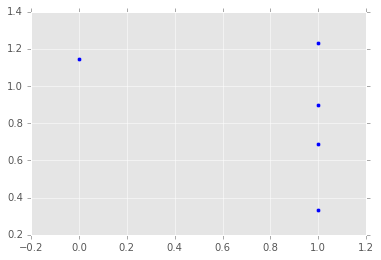

In [383]:
x = sample_form
y = sample_concreteness

plt.scatter(x,y)
plt.show()

In [384]:
X = list(zip(sample_form, sample_concreteness))

In [385]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

centroids = kmeans.cluster_centers_
labels = kmeans.labels_

print(centroids)
print(labels)

[[ 1.          0.78790064]
 [ 0.          1.14285714]]
[0 0 1 0 0]


coordinate: (1, 0.33333333333333331) label: 0
coordinate: (1, 0.90000000000000002) label: 0
coordinate: (0, 1.1428571428571428) label: 1
coordinate: (1, 0.6875) label: 0
coordinate: (1, 1.2307692307692308) label: 0


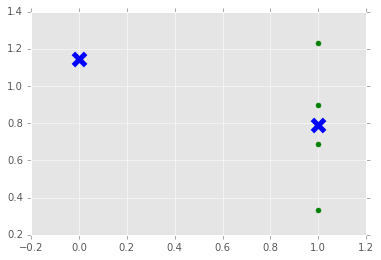

In [386]:
colors = ["g.","r."]

for i in range(len(X)):
    print("coordinate:",X[i], "label:", labels[i])
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize = 10)


plt.scatter(centroids[:, 0], 
            centroids[:, 1], 
            marker = "x", 
            s = 150, 
            linewidths = 5, 
            zorder = 10)

plt.show()

In [387]:
#Classify each poem
classification = []
for i in range(output_tb.num_rows):
    form = output_tb.column('Form')[i]
    concrete = output_tb.column('Concrete/Abstract')[i]
    X = list(zip(form, concrete))
    kmeans.fit(X)
    classification.append(kmeans.labels_)

In [388]:
output_tb = output_tb.with_column('Class', classification)

In [389]:
output_tb.show()

Title,Form,Concrete/Abstract,Class
"Fan-Piece, For Her Imperial Lord","[0, 0, 0]","[1.368421052631579, 0.5625, 0.66666666666666663]",[1 0 0]
Grace Before Song,"[0, 1, 1, 0, 1, 1, 1, 1, 1, 1]","[0.82499999999999996, 0.66666666666666663, 0.34999999999 ...",[1 0 0 1 0 0 0 0 0 0]
"Ione, Dead the Long Year","[0, 0, 0, 0, 0, 0, 0, 1, 1]","[1.0, 0.78125, 0.625, 1.1111111111111112, 0.666666666666 ...",[1 1 1 1 1 1 1 0 0]
Ité,"[1, 1, 1, 0, 0]","[0.7441860465116279, 0.0, 0.46341463414634149, 0.6382978 ...",[1 1 1 0 0]
Meditatio,"[0, 1, 1, 1, 0]","[0.53846153846153844, 0.57692307692307687, 0.70967741935 ...",[1 0 0 0 1]
Notes for Canto CXX,"[0, 0, 0, 1, 1, 0, 0, 0]","[0.69999999999999996, 1.3636363636363635, 1.0, 0.3125, 0 ...",[0 0 0 1 1 0 0 0]
Statement of Being,"[1, 1, 1, 1, 0, 0, 0, 0]","[1.6956521739130435, 0.61904761904761907, 0.310344827586 ...",[1 1 1 1 0 0 0 0]
Taking Leave of a Friend,"[0, 1, 1, 0, 0, 1, 1, 1, 0]","[0.625, 0.69999999999999996, 0.75, 1.0, 1.16129032258064 ...",[1 0 0 1 1 0 0 0 1]
Tame Cat,"[0, 0, 1, 1, 1, 1, 0]","[0.92307692307692313, 0.65909090909090906, 1.5, 0.795454 ...",[1 1 0 0 0 0 1]
The Seeing Eye,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]","[1.2285714285714286, 0.21875, 0.24242424242424243, 0.724 ...",[0 0 0 0 0 0 0 0 1 1]


***Note that the removal of "-" w/o adding a space affected poems like 
"Alba"***

***Below cells deal with advanced visualization packages:***

In [347]:
#!pip install pydot
#error described here: http://stackoverflow.com/questions/17886647/cant-install-via-pip-because-of-egg-info-error
#file from answer post: https://bitbucket.org/pypa/setuptools/raw/bootstrap/ez_setup.py

In [348]:
#!pip install --upgrade setuptools

***Write your own bibliography-formatting function because that would be cute***